# Moon - Earth Collision (Here Comes the Moon)

## Emma and Michael

In [301]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *
import math

## Question

The moon currently has a stable orbit around the earth, only drifting outwards by 4 cm a year. But what if we wanted to throw off that orbit completely?

Fred is an Olin first-year student who, well, let’s just say he enjoys being at school, but his work is not quality enough to give him a competitive edge in the real world. Luckily, he’s self-aware enough to realize this problem. He figures the only reasonable solution is to end the world on the day of his graduation from Olin (May 20, 2018) by crashing the moon into the earth.

His plan is to crash large amounts of replicas of Saturn V rockets into the moon. The effects of these rockets are twofold. First off, the mass transferred from the earth to the moon in the form of rockets will increase the gravitational force between the two bodies, as described by the Law of Universal Gravitation. Secondly, the rockets crash into the moon’s orbital path, thus slowing the moon down, decreasing its momentum and its ability to hold a stable orbit around the earth.

Before he can start on the non-trivial task of raising money for his creation of these rockets (his kickstarter goal may well be larger than the sum total of the economic production of the human race since the beginning of time), he must answer the question,

### How many rockets per second must hit the moon, starting December 14, 2018, to cause the moon to crash into the earth on May 20, 2022?


## Model

In Fred’s version of our universe, everything is flat (2-d) and only the moon and earth exist (i.e. the sun is not a part of the model, nor are the other planets of our solar system). The moon and earth both exert gravitational force on and move around each other. They were in a realistic, stable orbit until Fred began launching rockets into the moon’s orbital path, increasing its mass to eventually cause it to fall to the Earth. Fred’s system for launching rockets miraculously transports the mass from the Earth without changing the Earth’s momentum, so the earth's mass decreases at the same rate that the moon's mass increases.

We begin with establishing parameters for the model. The masses of the earth and the moon reflect actual values, and the moon’s initial position and velocity are that of its perigee. earth_radius and moon radius are functions that calculate the radii based on the bodies’ masses, which are constantly changing. It also contains the number of rockets sent to the moon per second, which is the parameter we are trying to optimize.

In [302]:
def earth_radius(mass):
    density = 5514 # 5514 kg/m3 from NASA Earth Fact Sheet
    Re = (3*mass / (4*pi*density))**(1/3)
    return Re

def moon_radius(mass):
    density = 3344 # 3344 kg/m3 from NASA Moon Fact Sheet
    Rm = (3*mass / (4*pi*density))**(1/3)
    return Rm

In [342]:
params = Params(num_rockets = 2.4448e+08,
                r_e = earth_radius,
                r_m = moon_radius,
                G=6.674e-11, #N / kg**2 * m**2
                t_0=0,
                t_end=5*365*24*60*60, 
                x_0 = 362600000, # 362,600 km at perigee
                v_0 = 1078.2, # 1078.2 m/s at perigee
                Me_0 = 5.9722e24, # 5.9722×10^24 kg
                Mm_0 = 7.342e22); # 7.342×10^22 kg

The model’s System object contains its parameters, including dmdt, which is the mass rate of change of the moon as caused by the rockets being sent to it. Note that the earth is losing mass at the same rate. The initial condition of the simulation is includes the masses and the x and y positions and velocities of the moon and the earth.

In [21]:
def make_system(params):
    num_rockets, r_e, r_m, G, t_0, t_end, x_0, v_0, Me_0, Mm_0 = params
    
    dmdt = 6.54e6*num_rockets
    
    init = State(Me = Me_0, # Initial mass of earth
             Mm = Mm_0, #Initial mass of moon
             x_m=x_0, # 362,600 km at perigee
             y_m=0,
             vx_m=0,
             vy_m=v_0, # 1078.2 m/s at perigee
             x_e = 0,
             y_e = 0,
             vx_e = 0,
             vy_e = 0
            )
    system = System(init = init,
                dmdt =dmdt,
                r_e = earth_radius,
                r_m = moon_radius,
                G=6.674e-11, #N / kg**2 * m**2
                t_0=0,
                t_end=5*365*24*60*60, 
                x_0 = 362600000, # 362,600 km at perigee
                v_0 = 1078.2, # 1078.2 m/s at perigee
                Me_0 = 5.9722e24, # 5.9722×10^24 kg
                Mm_0 = 7.342e22) # 7.342×10^22 kg
    
    return system

system = make_system(params);

The net force on the moon is made up two forces:
- The force of gravitation
    - This is calculated using the Universal Law of Gravitation.
- The force of the collision with rockets, conserving momentum
    - This is equivalent to the mass sent to the moon times the negative of its velocity.

In [305]:
def net_force_moon(state, system):
    """Computes gravitational force on the moon.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    
    returns: vector
    """
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    
    #Gravitational Force
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    force= G * Me * Mm / r**2
    direction = math.atan2(y_m-y_e,x_m-x_e) + pi 
    gravitational_force = Vector(force * math.cos(direction), force*math.sin(direction) )
    
    # Moon momentum contribution
    collision_force = dmdt * -(Vector(vx_m,vy_m))
    
    return gravitational_force + collision_force

There is only one force on the earth, the gravitational pull of the moon. This is once again calculated using the Law of Universal Gravitation.

In [306]:
def net_force_earth(state, system):
    """Computes gravitational force on the earth.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    
    #Gravitational Force
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    force= G * Me * Mm / r**2
    direction = math.atan2(y_m-y_e,x_m-x_e)
    gravitational_force = Vector(force * math.cos(direction), force*math.sin(direction) )
    
    return gravitational_force

Each time step forward is calculated by the slope function. It updates the masses of the earth and the moon, as well as their position and velocity in two dimensions. To do so, it calls the net force functions and uses F = MA to calculate the change in velocity within the time step.

In [307]:
def slope_func(state,t,system):
    
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    V_m = Vector(vx_m,vy_m)
    V_e = Vector(vx_e,vy_e)
    
    Fnet_m = net_force_moon(state,system)
    Fnet_e = net_force_earth(state,system)
    
    dMedt = -dmdt
    dMmdt = dmdt
    dxdt_m = V_m
    dvdt_m = Fnet_m / Mm
    dxdt_e = V_e
    dvdt_e = Fnet_e / Me
    
    return dMedt, dMmdt, dxdt_m[0], dxdt_m[1], dvdt_m[0], dvdt_m[1], dxdt_e[0], dxdt_e[1], dvdt_e[0], dvdt_e[1],

The simulation ends, as defined by the event func, when:
- The surfaces of the moon and earth collide (the distance between the centers of the bodies are less than the sum of their radii)
- The earth has negative mass
- The distance between the moon and the earth reaches ten times its initial value

In [25]:
def event_func(state,t,system):
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
   
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    collision_radius = earth_radius(Me) + moon_radius(Mm)
    
    #End the simulation if there is a collision OR if the orbital radius exceeds its initial value at apogee
    if(Me < 0):
        print('Negative mass is really sad...')
        return 0
    elif(r > 3.626e9):
        print('The moon escaped our experiment!')
        return 0
    else:
        return r - collision_radius


A single run of the simulation is demonstrated below, with a billion rockets per second thrown at the moon.

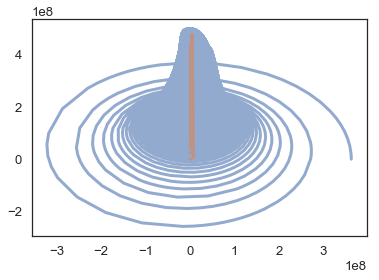

In [26]:
params = Params(params, num_rockets=1e9)
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, method="LSODA")
results.index /= 24*60*60*365

plot(results.x_m,results.y_m)
plot(results.x_e,results.y_e)

In [335]:
def error_func(rockets, params):
    params = Params(params, num_rockets=rockets)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func, method="LSODA")
    results.index /= 24*60*60*365
    return abs(results.index[-1] - 3.52)

In [349]:
rocks = linspace(1.8e8, 2.4e8, 22)
sweep = SweepSeries()

for rock in rocks:
    dday = error_func(rock, params)*365
    print(rock, dday)
    sweep[rock] = dday

180000000.0 136.3132489281276
182857142.85714287 152.2267403958579
185714285.7142857 123.92892998253046
188571428.57142857 121.55790768713968
191428571.42857143 44.08567279322594
194285714.2857143 30.881192479710148
197142857.14285713 45.699701848479464
200000000.0 39.806601773336915
202857142.85714287 89.84737224724157
205714285.71428573 47.36136616190376
208571428.57142857 2.5136675326965863
211428571.42857143 78.98888866335841
214285714.28571427 5.345155899282434
217142857.14285713 2.148718537067864
220000000.0 8.380343479797308
222857142.85714287 97.08918638314553
225714285.71428573 28.182071603322466
228571428.57142857 102.51965488288094
231428571.42857143 59.40555336646757
234285714.2857143 16.61516793476928
237142857.14285713 76.50132405053435
240000000.0 115.42650021265004


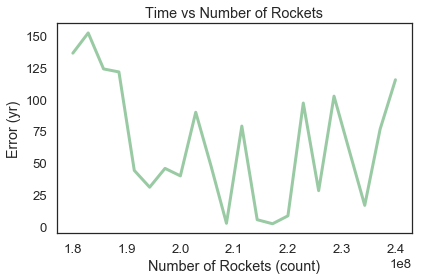

In [350]:
plot(sweep, color='C2')
decorate(xlabel='Number of Rockets (count)',
         ylabel='Error (yr)',
         title='Time vs Number of Rockets',
         legend=False)


In [338]:
%time res = min_bounded(error_func, [1e7, 1e10], params)

Wall time: 11min 57s


In [339]:
res

,values
fun,0.035087
status,0
success,True
message,Solution found.
x,2.4448e+08
nfev,35


,values
sol,None
t_events,[[98834730.31202394]]
nfev,36335
njev,340
nlu,340
status,1
message,A termination event occurred.
success,True


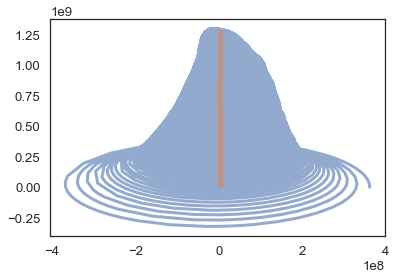

In [344]:
results, details = run_ode_solver(system,slope_func, events=event_func,method='LSODA')
plot(results.x_m,results.y_m)
plot(results.x_e,results.y_e)
details

In [345]:
results.index[-1] /( 24*60*60*365)

3.1340287389657515

In [323]:
results.head()

,Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e
0.000000e+00,5.972200e+24,7.342000e+22,362600000.0,0.000000,0.000000e+00,1078.2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.932923e-08,5.972200e+24,7.342000e+22,362600000.0,0.000032,-8.891307e-11,1078.2,3.205873e-20,0.000000e+00,1.093064e-12,9.532742e-26
5.865846e-08,5.972200e+24,7.342000e+22,362600000.0,0.000063,-1.778261e-10,1078.2,9.617619e-20,5.591760e-33,2.186128e-12,2.859823e-25
2.933510e-04,5.972200e+24,7.342000e+22,362600000.0,0.316291,-8.893086e-07,1078.2,1.603578e-12,6.992497e-22,1.093283e-08,4.768278e-18
5.866433e-04,5.972200e+24,7.342000e+22,362600000.0,0.632519,-1.778439e-06,1078.2,6.413029e-12,4.194939e-21,2.186347e-08,1.906930e-17


In [324]:
results.tail()

,Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e
1.234736e+08,5.813009e+24,2.326107e+23,5.773534e+06,1.585608e+09,6599.096654,3451.905793,4.915831e+06,1.596395e+09,-264.065053,-124.876015
1.234739e+08,5.813009e+24,2.326111e+23,7.716005e+06,1.586790e+09,6400.434906,4501.921123,4.838103e+06,1.596352e+09,-256.115916,-166.893252
1.234742e+08,5.813008e+24,2.326115e+23,9.556396e+06,1.588299e+09,5898.637038,5636.260862,4.764459e+06,1.596295e+09,-236.036553,-212.284929
1.234745e+08,5.813008e+24,2.326119e+23,1.119349e+07,1.590141e+09,5025.471417,6721.397101,4.698949e+06,1.596225e+09,-201.096563,-255.707843
1.234745e+08,5.813008e+24,2.326120e+23,1.138383e+07,1.590402e+09,4885.179629,6848.094765,4.691333e+06,1.596215e+09,-195.482723,-260.777803


## Code we are not currently using

In [336]:
def fsolve2(func, x0, *args, **options):
    """Return the roots of the (non-linear) equations
    defined by func(x) = 0 given a starting estimate.

    Uses scipy.optimize.fsolve, with extra error-checking.

    func: function to find the roots of
    x0: scalar or array, initial guess
    args: additional positional arguments are passed along to fsolve,
          which passes them along to func

    returns: solution as an array
    """
    # make sure we can run the given function with x0
    try:
        func(x0, *args)
    except Exception as e:
        msg = """Before running scipy.optimize.fsolve, I tried
                 running the error function you provided with the x0
                 you provided, and I got the following error:"""
        logger.error(msg)
        raise(e)

    # make the tolerance more forgiving than the default
    underride(options, xtol=1e-2)

    x0 = magnitude(x0)

    # run fsolve
    with units_off():
        result = scipy.optimize.fsolve(func, x0, args=args, **options)

    return result